# 9. Iterative CS-based MR image reconstruction from Cartesian data

In this tutorial we will reconstruct an MR image from Cartesian under-sampled kspace measurements.

We use the toy datasets available in pysap, more specifically a 2D brain slice
and the cartesian acquisition scheme.
We compare zero-order image reconstruction with Compressed sensing
reconstructions (analysis vs synthesis formulation) using the FISTA algorithm
for the synthesis formulation and the Condat-Vu algorithm for the analysis
formulation.Sparsity will be promoted in the wavelet domain, using either
Symmlet-8 (analysis and synthesis) or undecimated bi-orthogonal wavelets
(analysis only).

We remind that the synthesis formulation reads (minimization in the sparsifying domain):

$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \|y - \Omega F \Psi^*z \|_2^2 + \lambda \|z\|_1
$$

and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform,
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):

$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \|y - \Omega F x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021
- Update: 04/02/2025
- Target: ATSI MSc students, Paris-Saclay University

(256, 256)


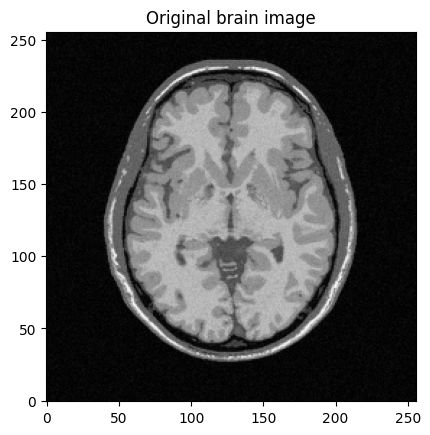

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters

import pywt as pw
import matplotlib.pyplot as plt

import brainweb_dl as bwdl

plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

mri_img = bwdl.get_mri(4, "T1")[70, ...].astype(np.float32)
#mri_img = bwdl.get_mri(4, "T2")[120, ...].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
plt.title("Original brain image")
plt.show()


In [6]:
#image = get_sample_data('2d-mri')
# Obtain K-Space Cartesian Mask
#mask = get_sample_data("cartesian-mri-mask")
image = mri_img 
from mrinufft.trajectories.tools import get_random_loc_1d

phase_encoding_locs = get_random_loc_1d(image.shape[0], accel=8, center_prop=0.1, pdf='gaussian')
print(phase_encoding_locs, min(phase_encoding_locs), max(phase_encoding_locs))
phase_encoding_locs = ((phase_encoding_locs +0.5) * image.shape[0]).astype(int)
mask = np.zeros(image.shape, dtype=bool)
mask[phase_encoding_locs] = 1

[ 0.          0.00390625 -0.00390625  0.0078125  -0.0078125   0.01171875
 -0.01171875  0.015625   -0.015625    0.01953125 -0.01953125  0.0234375
 -0.0234375   0.02734375 -0.02734375  0.03125    -0.03125     0.03515625
 -0.03515625  0.0390625  -0.0390625   0.04296875 -0.04296875  0.046875
 -0.046875    0.05078125 -0.05078125  0.0625     -0.06640625  0.08203125
 -0.13671875  0.09765625 -0.140625    0.109375   -0.14453125  0.11328125
 -0.19140625  0.1328125  -0.1953125   0.13671875 -0.2109375   0.1484375
 -0.234375    0.16015625 -0.28125     0.171875   -0.28515625  0.17578125
 -0.3515625   0.18359375  0.31640625  0.3203125   0.46875   ] -0.3515625 0.46875


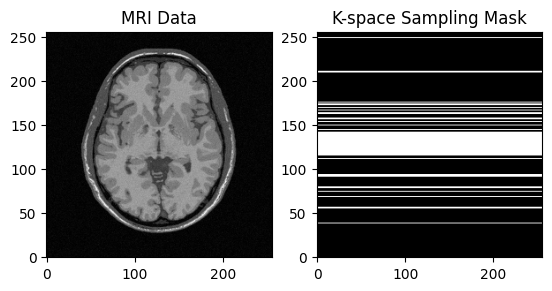

In [7]:
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask.
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [ ]:
# Get the locations of the kspace samples
kspace_loc = convert_mask_to_locations(mask.data)
# Generate the subsampled kspace
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

Zero order solution

In [ ]:
zero_soln = fourier_op.adj_op(kspace_data)
base_ssim = ssim(zero_soln, image)
plt.imshow(np.abs(zero_soln), cmap='gray')
plt.title('Zero Order Solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

Synthesis formulation: FISTA vs POGM optimization
------------------------------------------------------------

We now want to refine the zero-order solution using compressed sensing reconstruction.
Here we adopt the synthesis formulation based on the FISTA algorithm.
The cost function is set to Proximity Cost + Gradient Cost

In [ ]:
# Setup the operators
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")
# Setup Reconstructor
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

In [ ]:
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=200,
)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative Reconstruction FISTA: SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

## POGM optimization

In [ ]:
image_rec2, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='pogm',
    num_iterations=200,
)
recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('Iterative Reconstruction POGM: SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()

Analysis formulation: Condat-Vu reconstruction
---------------------------------------------------------------------

In [ ]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

In [ ]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

In [ ]:
image_rec3, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='condatvu',
    num_iterations=200,
)
recon3_ssim = ssim(image_rec3, image)
plt.imshow(np.abs(image_rec3), cmap='gray')
plt.title('Iterative Reconstruction Condat-Vu: SSIM = ' + str(np.around(recon3_ssim, 3)))
plt.show()